<a href="https://colab.research.google.com/github/hamza3e/Minutiae-Extraction/blob/master/Minutiae_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving fp1.bmp to fp1.bmp


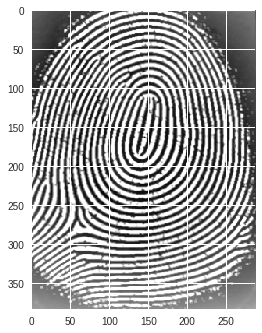

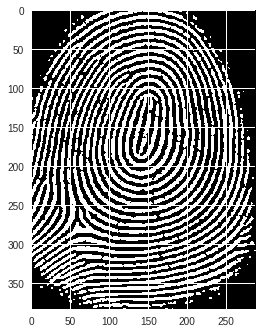

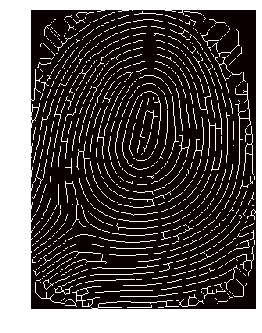

In [0]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
"load image data"
Img_Original =  io.imread( 'fp1.bmp')      # Gray image, rgb images need pre-conversion



imgplot = plt.imshow(Img_Original)      #
plt.show()



from skimage.filters import threshold_otsu

Otsu_Threshold = threshold_otsu(Img_Original)   
BW_Original = Img_Original > Otsu_Threshold    # must set object region as 1, background region as 0 !

imgplot = plt.imshow(BW_Original)         #
plt.show()



from skimage.morphology import skeletonize
BW_Skeleton = skeletonize(BW_Original)



# BW_Skeleton = BW_Original
"Display the results"

imgplot = plt.imshow(BW_Skeleton)
imgplot.set_cmap('hot')
plt.axis('off')                                   
plt.savefig('skeleton.png')

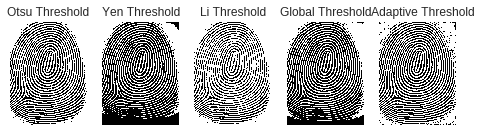

In [0]:
import cv2 as cv
import skimage.io as io
import numpy as np
from matplotlib import pyplot as plt

from skimage.filters import threshold_otsu
from skimage.filters import threshold_yen
from skimage.filters import threshold_li

img = io.imread('fp1.bmp')

Otsu_Threshold = threshold_otsu(img)   
th1 = img > Otsu_Threshold

Yen_Threshold = threshold_yen(img)   
th2 = img > Yen_Threshold

Li_Threshold = threshold_li(img)   
th3 = img > Li_Threshold

ret,th4 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th5 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)

# plot all the images and their histograms
images = [th1,
          th2,
          th3,
          th4,
          th5]
titles = ['Otsu Threshold',
          "Yen Threshold",
          "Li Threshold",
          "Global Threshold",
          "   Adaptive Threshold"]
for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i]), plt.xticks([]), plt.yticks([])

plt.savefig('thresholds.png')

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls

datalab


In [0]:
!cp skeleton.png drive/

In [0]:
uploaded = drive.CreateFile({'title': 'Sample.bmp'})
uploaded.GetContentFile('fp1.bmp')
uploaded.Upload()


In [0]:
# Converting Image to Greyscale ....
from PIL import Image,ImageDraw
img = Image.open('skeleton.png').convert('L')
img.save('thinned_greyscale.gif')

# Loading Image ....
Img_Original = io.imread('thinned_greyscale.gif')

In [0]:
# To reach different pixels from given pixel ....

cells = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

In [0]:
# Function to determine type of minutiae at pixel P(i,j) ....

def minutiae_at(pixels, i, j):
    values = [pixels[i + k][j + l] for k, l in cells]

    crossings = 0
    for k in range(0, 8):
        crossings += abs(values[k] - values[k + 1])
    crossings /= 2

    if pixels[i][j] == 1:
        if crossings == 1:
            return "ending"
        if crossings == 3:
            return "bifurcation"
    return "none"

In [0]:
# Function to convert the image into pixels ....

def load_image(im):
    (x,y) = im.size
    im_load = im.load()

    result = []
    for i in range(0, x):
        result.append([])
        for j in range(0, y):
            result[i].append(im_load[i, j])

    return result

In [0]:
# Function to apply particular property to each pixel ....

def apply_to_each_pixel(pixels, f):
    for i in range(0, len(pixels)):
        for j in range(0, len(pixels[i])):
            pixels[i][j] = f(pixels[i][j])

In [0]:
# Function to show minutiae on the image ....

def show_minutiaes(im):
    pixels = load_image(im)
    apply_to_each_pixel(pixels, lambda x: 0.0 if x > 10 else 1.0)

    (x, y) = im.size
    result = im.convert("RGB")

    draw = ImageDraw.Draw(result)

    colors = {"ending" : (150, 0, 0), "bifurcation" : (0, 150, 0)}

    ellipse_size = 8
    for i in range(1, x - 1):
        for j in range(1, y - 1):
            minutiae = minutiae_at(pixels, i, j)
            if minutiae != "none":
                draw.ellipse([(i - ellipse_size, j - ellipse_size), (i + ellipse_size, j + ellipse_size)], outline = colors[minutiae])

    del draw

    return result

In [0]:
# Applying Minutiae Detection Algorithm to image ....
Minutiae_Image = show_minutiaes(img)

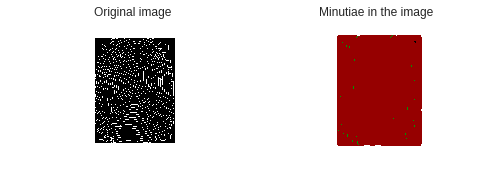

In [0]:
# Displaying the results ....
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.ravel()
ax1.imshow(Img_Original, cmap=plt.cm.gray)
ax1.set_title('Original image')
ax1.axis('off')
ax2.imshow(Minutiae_Image, cmap=plt.cm.gray)
ax2.set_title('Minutiae in the image')
ax2.axis('off')
plt.show()

In [0]:
# Saving the image ....
Minutiae_Image.save('minutiae_image.gif')

In [0]:
!ls

fp1.bmp		    sample_data   thinned_greyscale.gif
minutiae_image.gif  skeleton.png  thresholds.png


In [0]:
import cv2
import numpy as np
import skimage.morphology
import skimage
import skimage.io as io
from matplotlib import pyplot as plt

from getTerminationBifurcation import getTerminationBifurcation;
from removeSpuriousMinutiae import removeSpuriousMinutiae

img = cv2.imread('1.jpg',0);
img = np.uint8(img>128);
    
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255;
    
mask = img*255;
(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask);
    
minutiaeTerm = skimage.measure.label(minutiaeTerm, 8);
RP = skimage.measure.regionprops(minutiaeTerm)
minutiaeTerm = removeSpuriousMinutiae(RP, np.uint8(img), 10);
    
BifLabel = skimage.measure.label(minutiaeBif, 8);
TermLabel = skimage.measure.label(minutiaeTerm, 8);
    
minutiaeBif = minutiaeBif * 0;
minutiaeTerm = minutiaeTerm * 0;
    
(rows, cols) = skel.shape
DispImg = np.zeros((rows,cols,3), np.uint8)
DispImg[:,:,0] = skel; DispImg[:,:,1] = skel; DispImg[:,:,2] = skel;
    
    
RP = skimage.measure.regionprops(BifLabel)
for i in RP:
    (row, col) = np.int16(np.round(i['Centroid']))
    minutiaeBif[row, col] = 1;
    (rr, cc) = skimage.draw.circle_perimeter(row, col, 3);
    skimage.draw.set_color(DispImg, (rr,cc), (255,0,0));
    
    
RP = skimage.measure.regionprops(TermLabel)
for i in RP:
    (row, col) = np.int16(np.round(i['Centroid']))
    minutiaeTerm[row, col] = 1;
    (rr, cc) = skimage.draw.circle_perimeter(row, col, 3);
    skimage.draw.set_color(DispImg, (rr,cc), (0, 0, 255));


plt.imshow(DispImg)
plt.axis('off')
plt.show()

ModuleNotFoundError: ignored

In [0]:
import numpy as np
#import cv2
#import numpy as np;
import matplotlib.pylab as plt;
import scipy.ndimage
import sys

from image_enhance import image_enhance


if(len(sys.argv)<2):
    print('loading sample image');
    img_name = '1.jpg'
    img = scipy.ndimage.imread('fp1.png' + img_name);
elif(len(sys.argv) >= 2):
    img_name = sys.argv[1];
    img = scipy.ndimage.imread(sys.argv[1]);
    
if(len(img.shape)>2):
    # img = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
    img = np.dot(img[...,:3], [0.299, 0.587, 0.114]);

rows,cols = np.shape(img);
aspect_ratio = np.double(rows)/np.double(cols);

new_rows = 350;             # randomly selected number
new_cols = new_rows/aspect_ratio;

#img = cv2.resize(img,(new_rows,new_cols));
img = scipy.misc.imresize(img,(np.int(new_rows),np.int(new_cols)));

enhanced_img = image_enhance(img);    

if(1):
    print('saving the image')
    scipy.misc.imsave('../enhanced/' + img_name,enhanced_img);
else:
    plt.imshow(enhanced_img,cmap = 'Greys_r');

FileNotFoundError: ignored